In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from decouple import config
import math
import kagglehub
import os
import scipy.stats as stats
from scipy.stats import mstats
import statsmodels.api as sm


In [3]:
KAGGLE_USER = config("KAGGLE_USER")
KAGGLE_KEY = config("KAGGLE_KEY")

# Download latest version of the dataset
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

# List files in the dataset directory
print("Files in dataset:", os.listdir(path))

# Get file name
file_path = os.path.join(path, "breast-cancer.csv")

# Get destination directory from DATA_PATH env variable
data_dir = config("DATA_PATH")
dest_file_path = os.path.join(data_dir, "breast-cancer.csv")

# Move the file to DATA_PATH
os.replace(file_path, dest_file_path)

# Load the CSV from DATA_PATH
df = pd.read_csv(dest_file_path)

# Convert the target variable to binary (M: 1, B: 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Display first few rows
print(df.head())

Files in dataset: ['breast-cancer.csv']
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_w

In [4]:
# Check for missing values
print("Missing Values in Dataset:")
print(df.isnull().sum())

Missing Values in Dataset:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [5]:
# Dataset Description
print("Dataset Description:")
print(df.info())

Dataset Description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perim

## Swarm Plot + Box Plots (Checking for Outliers)

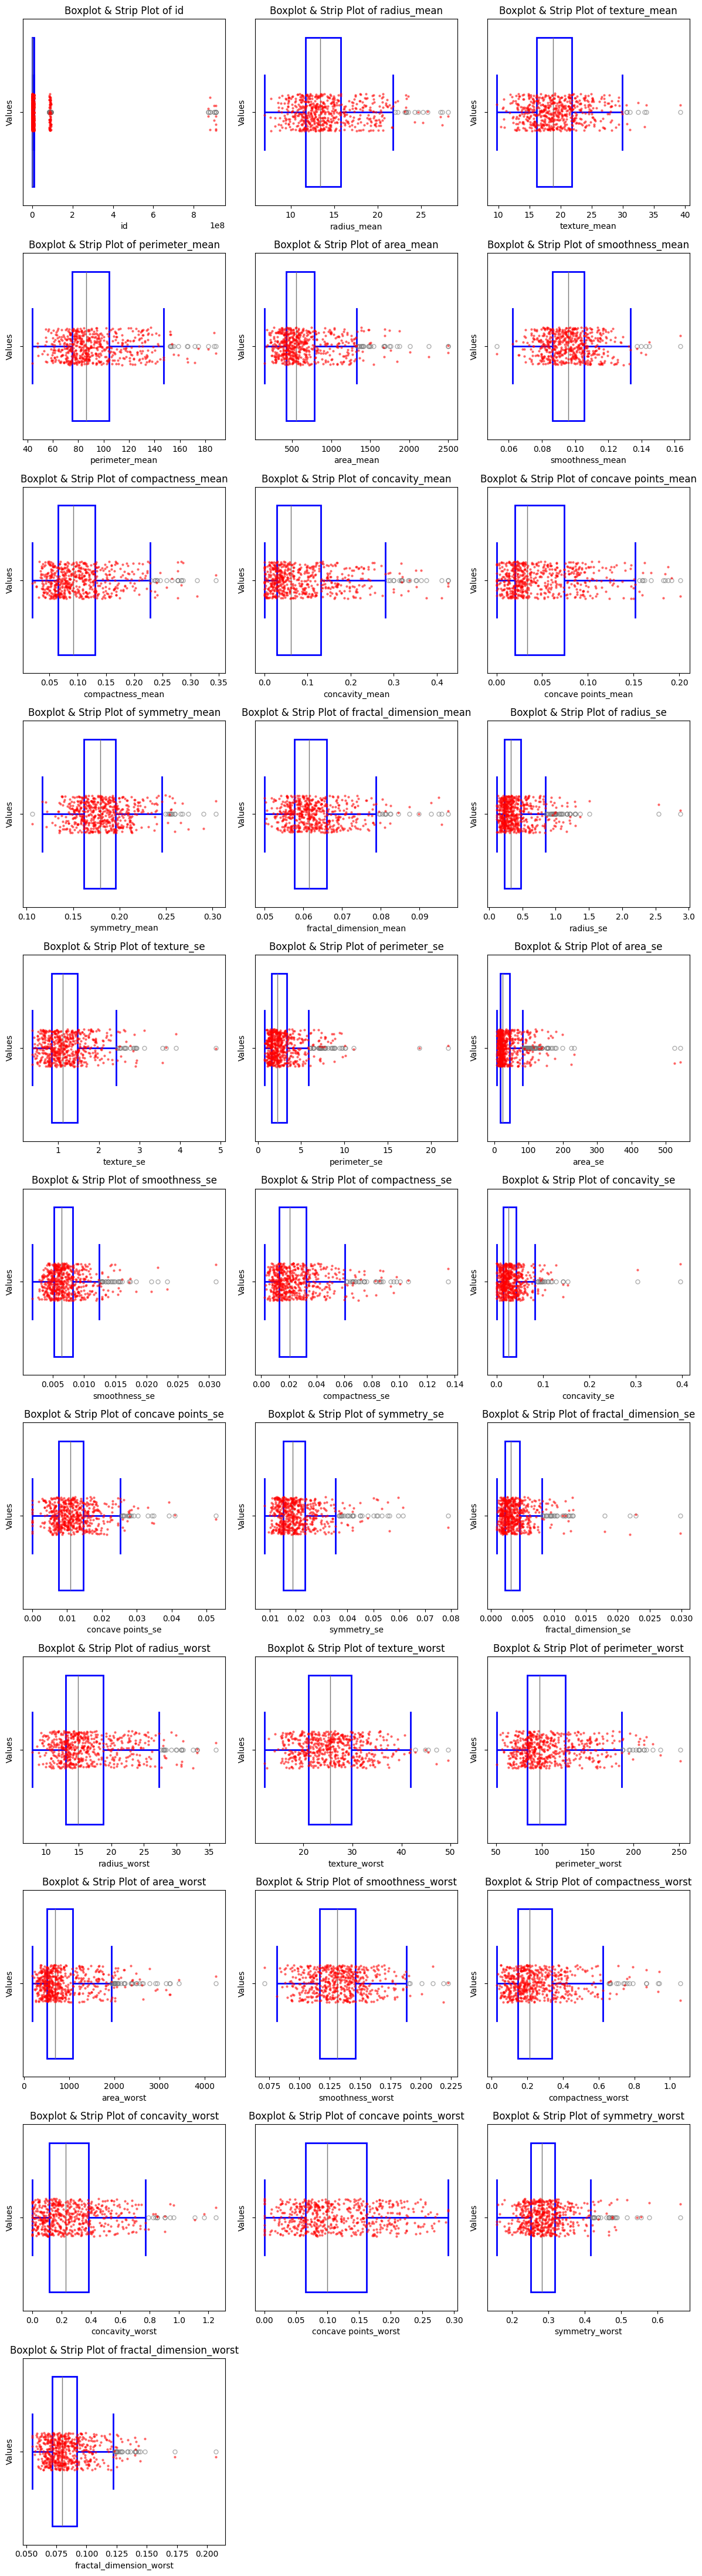

In [6]:
# List of variables to exclude
exclude_vars = ['diagnosis']

# Boxplots for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns
numerical_features = [feature for feature in numerical_features if feature not in exclude_vars]

n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)

plt.figure(figsize=(12, 4 * n_rows))
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[feature], color='lightblue', boxprops=dict(facecolor='none', linewidth=2, edgecolor='blue'),
                whiskerprops=dict(linewidth=2, color='blue'), capprops=dict(linewidth=2, color='blue'),
                flierprops=dict(marker='o', color='red', markersize=5, alpha=0.6), ax=ax)
    sns.stripplot(x=df[feature], color='red', alpha=0.6, jitter=True, size=3, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot & Strip Plot of {feature}')
plt.tight_layout()
plt.show()

In [15]:
# Remove 'id' and 'diagnosis' columns from features
feature_cols = [col for col in df.columns if col not in ['diagnosis', 'id']]

# Calculate IQR for each feature
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Winsorize the outliers for each feature
for feature in feature_cols:
    df[feature] = np.where(df[feature] < lower_bound[feature], lower_bound[feature],
                           np.where(df[feature] > upper_bound[feature], upper_bound[feature], df[feature]))

# Recount outliers after capping
outliers_list = []
for feature in feature_cols:
    outlier_count = ((df[feature] < lower_bound[feature]) | (df[feature] > upper_bound[feature])).sum()
    outliers_list.append({'Variable': feature, 'Outliers Count': outlier_count})
outliers = pd.DataFrame(outliers_list)
outliers_sorted_cnt = outliers.sort_values(by='Outliers Count', ascending=False)

print("Outliers sorted by Count after Winsorization:")
print(outliers_sorted_cnt.set_index("Variable"))

Outliers sorted by Count after Winsorization:
                         Outliers Count
Variable                               
radius_mean                           0
texture_mean                          0
perimeter_mean                        0
area_mean                             0
smoothness_mean                       0
compactness_mean                      0
concavity_mean                        0
concave points_mean                   0
symmetry_mean                         0
fractal_dimension_mean                0
radius_se                             0
texture_se                            0
perimeter_se                          0
area_se                               0
smoothness_se                         0
compactness_se                        0
concavity_se                          0
concave points_se                     0
symmetry_se                           0
fractal_dimension_se                  0
radius_worst                          0
texture_worst                     

In [17]:
# Logistic Regression Assumptions

from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import logit

# Ensure all column names are valid Python identifiers for statsmodels formulas
X_vif.columns = [col.replace(' ', '_') for col in X_vif.columns]
X_bt = X_vif.copy()
X_bt['diagnosis'] = y

# Box-Tidwell test: add interaction terms between each predictor and its log
results = {}
for col in X_vif.columns:
    X_bt[f'{col}_log'] = X_bt[col] * np.log(X_bt[col].replace(0, 1e-6))
    formula = f'diagnosis ~ {col} + {col}_log'
    model = logit(formula, data=X_bt).fit(disp=0)
    p_value = model.pvalues.get(f'{col}_log', np.nan)
    results[col] = p_value

print('Box-Tidwell test p-values (should be > 0.05 for linearity):')
print(pd.Series(results).sort_values())

# Clean up added columns
drop_cols = [f'{col}_log' for col in X_vif.columns]
X_bt = X_bt.drop(columns=drop_cols)

Box-Tidwell test p-values (should be > 0.05 for linearity):
symmetry_se                0.013547
id                         0.018063
smoothness_worst           0.023245
concave_points_se          0.031839
fractal_dimension_mean     0.073502
texture_mean               0.077984
smoothness_mean            0.090118
perimeter_se               0.138225
fractal_dimension_worst    0.220608
concavity_se               0.220870
symmetry_mean              0.249152
smoothness_se              0.271409
concave_points_mean        0.328246
symmetry_worst             0.350034
fractal_dimension_se       0.508959
compactness_se             0.684799
area_worst                 0.933338
texture_se                 0.945416
dtype: float64


c:\Users\John\Documents\Capstone Projects\Python Capstones\python-breast-cancer\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\John\Documents\Capstone Projects\Python Capstones\python-breast-cancer\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\John\Documents\Capstone Projects\Python Capstones\python-breast-cancer\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\John\Documents\Capstone Projects\Python Capstones\python-breast-cancer\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\John\Documents\Capstone Projects\Python Capstones\p